In [1]:
import pandas as pd
import env
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import acquire_r
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import sklearn.model_selection
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import logistic_regression_util
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import knn_lesson_util as util
import wrangle
import encode
from sklearn.model_selection import KFold, cross_val_score
import time
import model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from scipy import stats
sns.set()

### Start with acquiring data from SQL database

In [2]:
df = acquire_r.get_data_from_sql()

In [3]:
# check head of the dataset
df.head(4)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check


In [4]:
## check tail of the dataset
df.tail(4)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
7039,2,3,3,9953-ZMKSM,Male,0,No,No,63,Yes,...,No internet service,No internet service,No internet service,No,25.25,1559.3,No,Two year,None,Mailed check
7040,4,3,3,9964-WBQDJ,Female,0,Yes,No,71,Yes,...,No internet service,No internet service,No internet service,Yes,24.40,1725.4,No,Two year,None,Credit card (automatic)
7041,3,3,3,9972-EWRJS,Female,0,Yes,Yes,67,Yes,...,No internet service,No internet service,No internet service,Yes,19.25,1372.9,No,Two year,None,Bank transfer (automatic)
7042,4,3,3,9975-GPKZU,Male,0,Yes,Yes,46,Yes,...,No internet service,No internet service,No internet service,No,19.75,856.5,No,Two year,None,Credit card (automatic)


In [5]:
#check the shape of the dataset
df.shape

(7043, 24)

## Start with looking for missing values  data integrity issues 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

### Looks like there are no null values in dataset. However the total_charges is an 'object' instead of float. Lets explore it further

In [7]:
df.sort_values(by = 'total_charges')

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2048,3,1,3,4472-LVYGI,Female,0,Yes,Yes,0,No,...,Yes,Yes,No,Yes,52.55,,No,Two year,DSL,Bank transfer (automatic)
6143,2,3,2,2923-ARZLG,Male,0,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,Yes,19.70,,No,One year,None,Mailed check
1949,3,1,3,2775-SEFEE,Male,0,No,Yes,0,Yes,...,Yes,No,No,Yes,61.90,,No,Two year,DSL,Bank transfer (automatic)
1878,4,1,3,1371-DWPAZ,Female,0,Yes,Yes,0,No,...,Yes,Yes,No,No,56.05,,No,Two year,DSL,Credit card (automatic)
6615,2,3,3,3213-VVOLG,Male,0,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No,25.35,,No,Two year,None,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6341,2,3,2,8249-THVEC,Male,0,Yes,Yes,51,Yes,...,No internet service,No internet service,No internet service,No,19.40,997.75,No,One year,None,Mailed check
6261,4,3,2,6051-PTVNS,Female,0,Yes,Yes,55,Yes,...,No internet service,No internet service,No internet service,No,19.15,998.1,No,One year,None,Credit card (automatic)
3702,2,2,1,5899-MQZZL,Female,0,No,No,13,Yes,...,No,No,No,Yes,75.00,999.45,Yes,Month-to-month,Fiber optic,Mailed check
3392,4,2,1,4536-PLEQY,Male,0,Yes,No,12,Yes,...,No,No,Yes,Yes,85.05,999.8,No,Month-to-month,Fiber optic,Credit card (automatic)


### Looks like there are 11 rows with no total_charges_values.  All these 11 customers have tenure of zero. We decided to drop these 11 datapoints since we have fairly big dataset to work with. 

### Wrangle the dataset and split it into train, validate and test. The wrangle module (wrangle_telco.py ) does the following:

##### Replace spaces with 'NaN'.
##### Drop rows with those NaN values (total of 11 rows)
##### Changes total_charges column values from 'object' to 'float'
##### Changes 'Yes' to 1 and 'No' to 0. 
##### creates a new column 'tenure years' using 'tenure

***

In [8]:
#using wrangle_telco.py file to wrangle and split the data
df = wrangle.wrangle_telco(df)

In [9]:
# Split data into train and test (80:20 split).Random state is set to 42 
train, test = sklearn.model_selection.train_test_split(df, train_size=.8, random_state=42)

#The train dataset is split further (80:20) into train and validate. Random state is set to 42 
train, validate = sklearn.model_selection.train_test_split(train, train_size=.8, random_state=42)

In [10]:
# confirm the shape of train, validate and test dataset
train.shape, validate.shape, test.shape

((4500, 25), (1125, 25), (1407, 25))

# We will start with exploratory data analysis (EDA) below on the train dataset

In [11]:
train.head(2)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years
5217,4,2,3,3134-DSHVC,Female,0,0,0,63,1,...,1,0,0,98.0,6218.45,0,Two year,Fiber optic,Credit card (automatic),5.0
5496,3,2,3,9586-JGQKH,Female,0,1,0,64,1,...,1,1,1,105.4,6794.75,0,Two year,Fiber optic,Bank transfer (automatic),5.0


In [12]:
train.churn.value_counts()

0    3289
1    1211
Name: churn, dtype: int64

### This seems like a 'unbalanced dataset' where 74% are non-churners and 26% as churners
***

### Let's start with pair plot for continueous variables: tenure, total charges and monthly charges

In [13]:
# create a dataset of continuous variable and 'churn'for 'hue'
train_cont = train[['tenure', 'total_charges', 'monthly_charges','churn']]

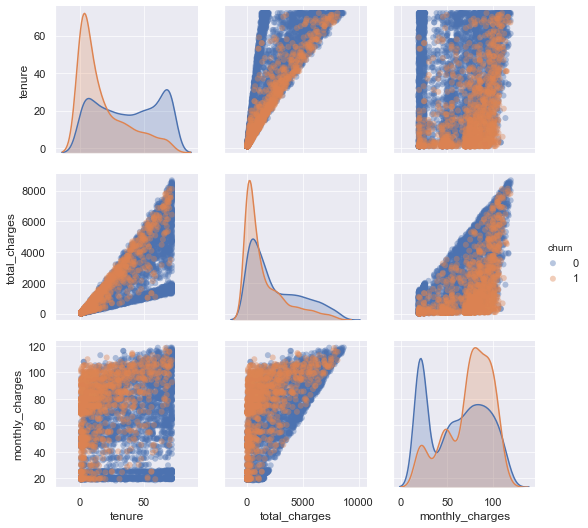

In [14]:
sns.pairplot(train_cont, vars = train_cont.columns[:-1], hue='churn', plot_kws=dict(alpha=.4, edgecolor='none'))

#### The pairplot above implies:
1. Churners seems to have much shorter tenure compared to non-churners
2. Churners might be paying more (or using higher priced services) than non-churners
3. Monthly charges for churners are higher (possibly due to subscription) to higher priced services compared to non-churners

### Lets do a statistical test to see if monthly charges (contineous variable) are different between churners/non-churners (categorical variable). We can do a two sample t-test.

#### $H_0$: There is no difference in monthly charges between churners and non-churners
#### $H_a$: There is difference in monthly charges between churners and non-churners

In [15]:
x1 = train[train.churn ==1].monthly_charges
x2 = train[train.churn ==0].monthly_charges

In [16]:
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=12.997107440581107, pvalue=6.081507718988995e-38)

### The p value is almost zero. This means that we can reject our null hypothesis which means that there is statistical difference between monthly charges for churners and non-churners
***

### Lets explore if there is any gender relationship with churners

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

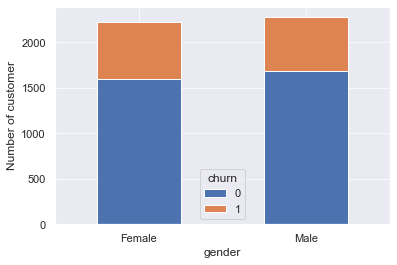

In [137]:
train_gender = pd.crosstab(train.gender, train.churn)
train_gender.plot(kind='bar', stacked=True)
plt.ylabel('Number of customer')
plt.xticks(rotation=0)

#### It seems like the rate of churn is same between male and females
***


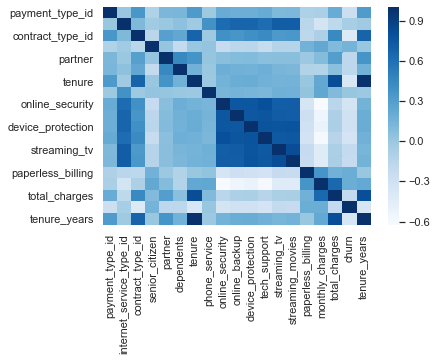

In [18]:
# Lets do a heatmap 
sns.heatmap(train.corr(), cmap='Blues')

### This chart looks too busy. We can just look at table of correlation instead below

In [19]:
corr = train.corr()
corr

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,partner,dependents,tenure,phone_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,tenure_years
payment_type_id,1.000000,0.010196,0.355552,-0.103203,0.123602,0.131392,0.331152,-0.012785,0.207083,0.187786,0.184068,0.212969,0.107194,0.116705,-0.094247,-0.083413,0.207307,-0.266530,0.327591
internet_service_type_id,0.010196,1.000000,0.109694,-0.029249,0.004398,0.051347,-0.017016,0.386718,0.621092,0.666058,0.667515,0.618590,0.714865,0.709063,-0.148740,-0.329540,-0.177037,-0.054453,-0.018147
contract_type_id,0.355552,0.109694,1.000000,-0.155734,0.285199,0.235638,0.675999,-0.009143,0.397776,0.362559,0.400807,0.432083,0.335675,0.349069,-0.167396,-0.089372,0.440414,-0.403699,0.674348
senior_citizen,-0.103203,-0.029249,-0.155734,1.000000,0.018139,-0.209509,0.009426,0.027526,-0.215005,-0.162786,-0.154695,-0.227421,-0.133915,-0.130352,0.157127,0.228021,0.103035,0.149408,0.006921
partner,0.123602,0.004398,0.285199,0.018139,1.000000,0.448175,0.375354,0.019449,0.073268,0.088690,0.094374,0.068276,0.073090,0.073642,-0.007685,0.089039,0.307353,-0.169257,0.367897
dependents,0.131392,0.051347,0.235638,-0.209509,0.448175,1.000000,0.165728,-0.000516,0.186705,0.165236,0.159343,0.180574,0.136003,0.124239,-0.112298,-0.119796,0.064202,-0.171815,0.161974
tenure,0.331152,-0.017016,0.675999,0.009426,0.375354,0.165728,1.000000,-0.002991,0.154416,0.192637,0.195737,0.164005,0.144816,0.155948,0.006441,0.230045,0.817362,-0.364808,0.988998
phone_service,-0.012785,0.386718,-0.009143,0.027526,0.019449,-0.000516,-0.002991,1.000000,0.131856,0.150252,0.134244,0.122561,0.175114,0.164008,0.034202,0.243624,0.104611,0.017386,-0.005153
online_security,0.207083,0.621092,0.397776,-0.215005,0.073268,0.186705,0.154416,0.131856,1.000000,0.758825,0.758639,0.800254,0.705387,0.716494,-0.342207,-0.622544,-0.158139,-0.327007,0.154427
online_backup,0.187786,0.666058,0.362559,-0.162786,0.088690,0.165236,0.192637,0.150252,0.758825,1.000000,0.746879,0.760471,0.724159,0.717200,-0.270229,-0.547190,-0.088103,-0.293977,0.193743


In [20]:
#The chart above is still to much information to look at.
# so instead  We can look at top 10 features corelated with churn
train.corr().iloc[17].sort_values()[0:10]

contract_type_id    -0.403699
tenure              -0.364808
tenure_years        -0.356645
tech_support        -0.333430
online_security     -0.327007
online_backup       -0.293977
device_protection   -0.289563
payment_type_id     -0.266530
streaming_movies    -0.211497
streaming_tv        -0.209256
Name: churn, dtype: float64

#### The features most correlated with churn is contract_type,Tenure, payment_type_id, and other value added services. 
#### However it is worth nothing that value added services like 'tech support', 'online security', 'online backup', 'device protection', 'streaming movies', 'streaming tv' are highly co-related themselves. So we should use only one of these features for modeling.

### We can further explore the features identified above as highly correlated with Churn

In [21]:
train.contract_type.value_counts()

Month-to-month    2480
Two year          1081
One year           939
Name: contract_type, dtype: int64

In [22]:
observed = pd.crosstab(train.churn, train.contract_type)
observed

contract_type,Month-to-month,One year,Two year
churn,,,
0,1402,836,1051
1,1078,103,30


### The cross tabulation suggest that month-to-month customers are more likely to churn than those with One or two year contract. We can do a statictical chi2 test to if these two groups are really different

### Null Hypothesis $H_0$ : There is no difference in churn rate between month-to-month and One-year contract customers
### Alternate Hypothesis $H_a$: The churn rate is different  between month-to-month and One-year contract customers


In [23]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1402  836 1051]
 [1078  103   30]]
---
Expected

[[1812.60444444  686.30466667  790.09088889]
 [ 667.39555556  252.69533333  290.90911111]]
---

chi^2 = 787.1229
p     = 0.0000


### The p value is less than 0.05, so we can reject the null hypothesis. This implies that rate of churn in month to month customers is significantly higher than other customers
***

### Next question to answer: Is there a tenure that month-to-month customers are most likely to churn? 1-year contract customers?

In [24]:
# Cross tabulation churn rate of month-to-month customers as function of tenure years (1= churn, 0 = no churn)
ten0 = pd.crosstab(train[train.contract_type_id ==1].tenure_years,train[train.contract_type_id ==1].churn, normalize = 'index')
ten0

churn,0,1
tenure_years,,
0.0,0.467662,0.532338
1.0,0.616438,0.383562
2.0,0.668693,0.331307
3.0,0.645933,0.354067
4.0,0.736486,0.263514
5.0,0.760000,0.240000
6.0,1.000000,0.000000


In [25]:
# Cross tabulation churn rate of one-year contract customers as function of tenure years (1= churn, 0 = no churn)
ten1 = pd.crosstab(train[train.contract_type_id ==2].tenure_years,train[train.contract_type_id ==2].churn, normalize = 'index')
ten1

churn,0,1
tenure_years,,
0.0,0.897059,0.102941
1.0,0.881890,0.118110
2.0,0.919753,0.080247
3.0,0.893750,0.106250
4.0,0.861244,0.138756
5.0,0.895000,0.105000
6.0,0.923077,0.076923


In [26]:
# Cross tabulation churn rate of two-year contract customers as function of tenure years (1= churn, 0 = no churn)
ten2 = pd.crosstab(train[train.contract_type_id ==3].tenure_years,train[train.contract_type_id ==3].churn, normalize = 'index')
ten2

churn,0,1
tenure_years,,
0.0,1.000000,0.000000
1.0,1.000000,0.000000
2.0,0.968254,0.031746
3.0,0.991150,0.008850
4.0,0.951220,0.048780
5.0,0.959732,0.040268
6.0,0.995238,0.004762


Text(0, 0.5, '% Churn')

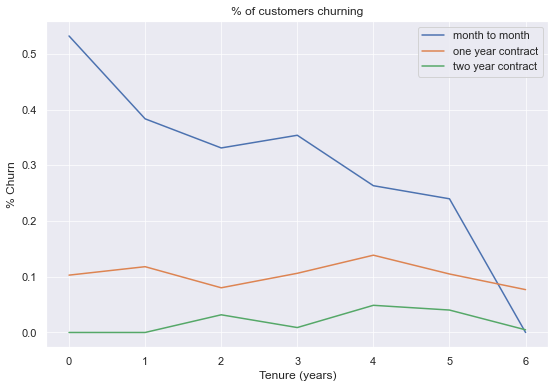

In [27]:
plt.figure(figsize = (9,6))
sns.lineplot( x = ten0.index, y = ten0[1], data = ten0, label = 'month to month')
sns.lineplot( x = ten1.index, y = ten1[1], data = ten1, label = 'one year contract')
sns.lineplot( x = ten2.index, y = ten2[1], data = ten2, label = 'two year contract')
#sns.lineplot( x = t.index, y = t[1], data = t, label = 'All Customers')
plt.title("% of customers churning")
plt.xlabel('Tenure (years)')
plt.ylabel('% Churn')

### Based on the chart above we can conclude that:
#### 1. Month-to month customers are most likely to churn early in their tenure (4-5 times higher!!)
#### 2. The churn rate for month-month customers declines longer they stay with the company
#### 3. The churn rate for one-year-contract and two-year-contract customers stays low and constant throughout their tenure
***


### Next we plot tenure vs  monthly charges for churners vs non churners

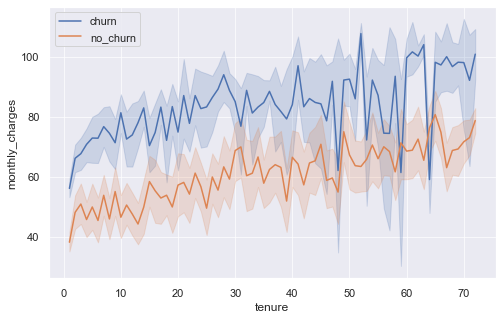

In [28]:
plt.figure(figsize = (8,5))
sns.lineplot(x='tenure', y = 'monthly_charges', data = train[train.churn==1], ci =95, label = 'churn')
sns.lineplot(x='tenure', y = 'monthly_charges', data = train[train.churn==0], ci =95, label = 'no_churn')

### From the chart  above we can conclude:
#### Churners (who are mostly month-to-month)  are paying more compared to non-churners. But why? Are they using higher priced services or are they charged more because of month-to-month contract?
***

Text(0, 0.5, 'no of customers churned')

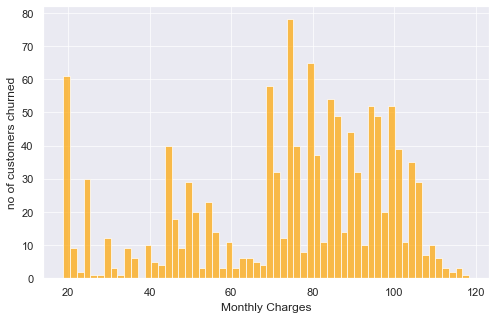

In [29]:
plt.figure(figsize = (8,5))
plt.hist(train[train.churn ==1].monthly_charges,bins = 60, alpha = 0.7, color = 'orange')
plt.xlabel('Monthly Charges')
plt.ylabel('no of customers churned')

#### The chart above shows that most of the churners have high monthly charges (possibly due to fact that they are subscribing to higher cost services e.g. Fiber optic
***

### The next question to explore is why these customers are paying more on average? Are they using higer priced services? Lets explore

##### Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

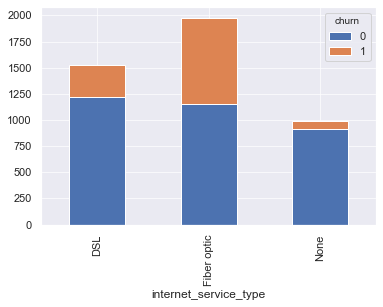

In [30]:
df_plot = pd.crosstab(train.internet_service_type, train.churn)
df_plot.plot(kind='bar', stacked=True)

### From this chart we can conclude that churuners are more likely to have Fiber optic > DSL > No internet. Which explains the fact that their average monthly charges are higher than non-churners
***

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

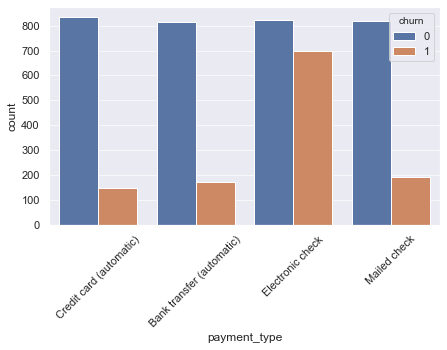

In [134]:
# Here we plot distrbution of payment type among churners and non-churners
plt.figure(figsize=(7, 4))

sns.countplot(x="payment_type", hue="churn",data=train)
plt.xticks(rotation=45)

### The chart suggests that Churners seems to prefer Electronic checks compared to other payment methods. There seems to be no preference among non-churners. So this feature could be useful for predicting churn
***

# Modeling: We will use classification ML algorithms to predict customers who will churn. 
### We need to be mindful of cost of False positives and False negatives and benefits of True Positives
### Cost of false fositive: We end up providing discounts to customers who will not churn
### Cost of false negative: We will lose customers who could have been retained (lost revenue)
### Maximize true positives: Will lead of higher revenues/profit.

### Given these constrints we will try to optimize our models to achieve higher F1 value (balance between recall and precision)
***


### Before we start modeling we need to encode and scale our predictors

In [32]:
# Create dataframes with  variables which have highest correlation with Churn:  
y_train = train[['churn']]
y_validate = validate[['churn']]
y_test = test[['churn']]
X_train = train[['senior_citizen', 'tech_support', 'contract_type', 'internet_service_type','payment_type','tenure_years', 'total_charges']]
X_validate = validate[['senior_citizen', 'tech_support', 'contract_type', 'internet_service_type','payment_type','tenure_years', 'total_charges']]
X_test = test[['senior_citizen','tech_support', 'contract_type', 'internet_service_type','payment_type','tenure_years', 'total_charges']]

In [33]:
# Next we do onehot encoding for these variables
l = ['contract_type','internet_service_type', 'payment_type','tenure_years']
X_train = encode.encode(X_train,l)
X_validate = encode.encode(X_validate,l)
X_test = encode.encode(X_test,l)
X_test.head(2)

,senior_citizen,tech_support,total_charges,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,tenure_years_0.0,tenure_years_1.0,tenure_years_2.0,tenure_years_3.0,tenure_years_4.0,tenure_years_5.0,tenure_years_6.0
2481,0,0,842.90,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6783,0,2,515.75,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [34]:
# Next we scale the total_charges column using min-max scaler
column_list = ['total_charges']
X_train_scaled = encode.scale_minmax(X_train, column_list)
X_validate_scaled = encode.scale_minmax(X_validate, column_list)
X_test_scaled = encode.scale_minmax(X_test, column_list)

# Logistic Regression Modeling

In [80]:
logit = LogisticRegression(C=0.21, random_state = 123)
logit.fit(X_train_scaled, y_train)
y_pred = logit.predict(X_train_scaled)
y_pred_proba = logit.predict_proba(X_train_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'], index = X_train_scaled.index)

In [36]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3289
           1       0.67      0.51      0.58      1211

    accuracy                           0.80      4500
   macro avg       0.75      0.71      0.72      4500
weighted avg       0.79      0.80      0.79      4500



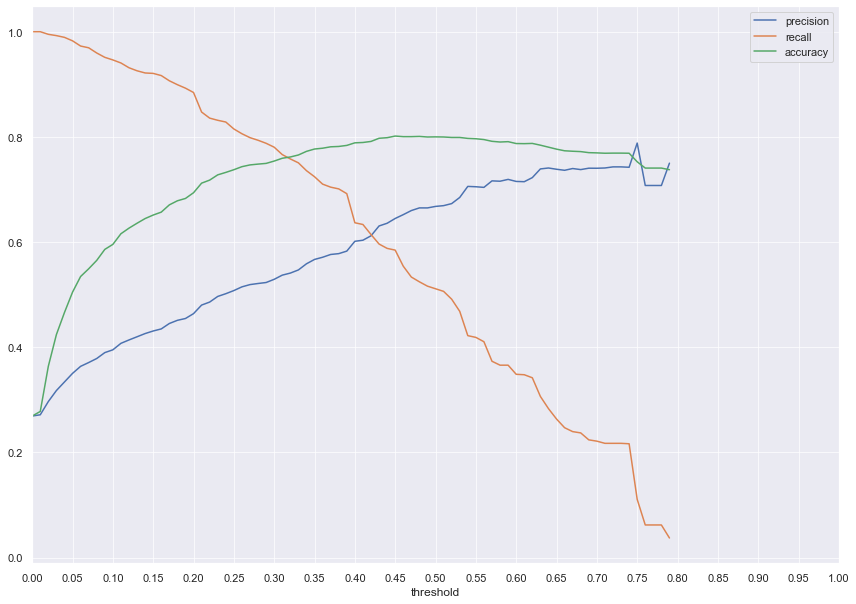

In [37]:
logistic_regression_util.plot_metrics_by_thresholds(y_train, y_pred_proba.churn)

#### We can use the chart above to tweak our model hyperparameters to optimize F1

In [81]:
y_pred_proba = logit.predict_proba(X_train_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'], index = X_train_scaled.index)
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_train, yhat.churn))

              precision    recall  f1-score   support

           0       0.90      0.74      0.82      3289
           1       0.53      0.78      0.63      1211

    accuracy                           0.75      4500
   macro avg       0.72      0.76      0.72      4500
weighted avg       0.80      0.75      0.77      4500



### The threshold of 0.3 leads to optimized F1-score. Lets try this model on our validate model

In [39]:
# We now run the model on validate dataset
y_pred = logit.predict(X_validate_scaled)
y_pred_proba = logit.predict_proba(X_validate_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_validate, yhat.churn))

              precision    recall  f1-score   support

           0       0.89      0.79      0.83       823
           1       0.56      0.73      0.63       302

    accuracy                           0.77      1125
   macro avg       0.72      0.76      0.73      1125
weighted avg       0.80      0.77      0.78      1125



## The model performs decently on test dataset!

***

In [40]:
#Next we look at weight of different variables from the logit model
weights = pd.Series(logit.coef_[0],
index=X_train_scaled.columns.values)
features = pd.DataFrame(weights.sort_values(ascending = False)).reset_index()
features.columns = ['features', 'weights']
#features.to_csv('features.csv')
features

,features,weights
0,tenure_years_0.0,0.901781
1,contract_type_Month-to-month,0.478686
2,internet_service_type_Fiber optic,0.395684
3,senior_citizen,0.238687
4,payment_type_Electronic check,0.181595
5,tenure_years_1.0,0.135497
6,tenure_years_3.0,-0.146190
7,tenure_years_2.0,-0.205897
8,tenure_years_4.0,-0.241093
9,payment_type_Bank transfer (automatic),-0.286611


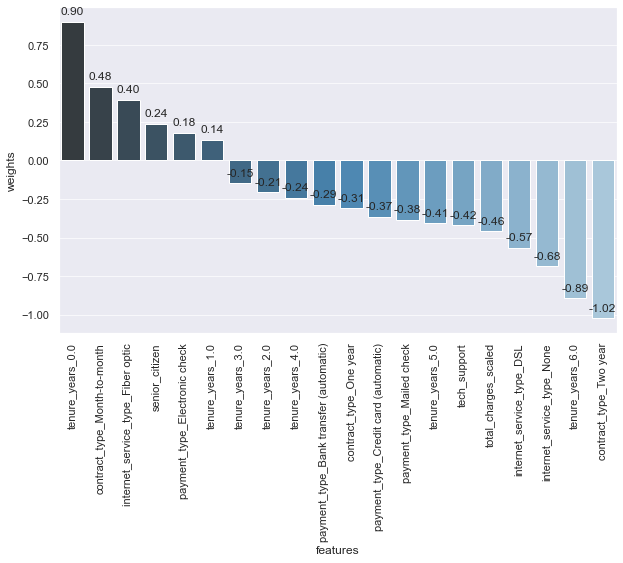

In [133]:
plt.figure(figsize = (10,6))
chart = sns.barplot(x = 'features', y = 'weights', data = features, palette=("Blues_d"))
sns.set()
plt.xticks(rotation=90)
for p in chart.patches:
    chart.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = "center", xytext = (0, 10), textcoords = 'offset points')

# Random Forest

In [42]:
# Create the RF model
clf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=1000,
                            max_depth=5, 
                            random_state=42)

In [43]:
# Fit the model on train dataset and then predict
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_train_scaled)

In [44]:
#classification report for train dataset with default threshold of 0.5
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.823911,0.697385,0.801333,0.760648,0.789862
recall,0.926117,0.462428,0.801333,0.694273,0.801333
f1-score,0.872030,0.556107,0.801333,0.714069,0.787012
support,3289.000000,1211.000000,0.801333,4500.000000,4500.000000


In [45]:
# Next we change the thershold to optimize for F1 score
y_pred_proba = clf.predict_proba(X_train_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_train, yhat.churn))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      3289
           1       0.53      0.81      0.64      1211

    accuracy                           0.75      4500
   macro avg       0.72      0.77      0.73      4500
weighted avg       0.81      0.75      0.77      4500



### The F1 score above looks good. Next we use this model on validation dataset

In [46]:
# use model on validation dataset and print classification report (threshold set to 0.3)
y_pred = clf.predict(X_validate_scaled)
y_pred_proba = clf.predict_proba(X_validate_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_validate, yhat.churn))

              precision    recall  f1-score   support

           0       0.91      0.76      0.82       823
           1       0.54      0.79      0.64       302

    accuracy                           0.77      1125
   macro avg       0.73      0.77      0.73      1125
weighted avg       0.81      0.77      0.78      1125



### The model's performance on validation dataset is similar to that on training dataset
***


# K Neighbor (KNN)

In [47]:
# create a model with 5 neightbors and uniform weight
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [48]:
# Fit the model on train data
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [49]:
# predict using train dataset and print classification report (default threshold of 0.5)
y_pred = knn.predict(X_train_scaled)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      3289
           1       0.74      0.65      0.69      1211

    accuracy                           0.84      4500
   macro avg       0.81      0.78      0.79      4500
weighted avg       0.84      0.84      0.84      4500



In [50]:
# use model on train dataset and using threshold value of 0.3
y_pred_proba = knn.predict_proba(X_train_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.30
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_train, yhat.churn))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      3289
           1       0.61      0.85      0.71      1211

    accuracy                           0.81      4500
   macro avg       0.77      0.83      0.79      4500
weighted avg       0.85      0.81      0.82      4500



In [51]:
# use model on validate dataset and using threshold value of 0.3
y_pred = knn.predict(X_validate_scaled)
y_pred_proba = knn.predict_proba(X_validate_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_validate, yhat.churn))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       823
           1       0.51      0.71      0.59       302

    accuracy                           0.74      1125
   macro avg       0.69      0.73      0.70      1125
weighted avg       0.78      0.74      0.75      1125



### The performance of KNN model is worse compared on validation vs train dataset (F1 value fell from 0.71 to 0.59) 
***

## Next we plot the ROC curves for all three models above to choose the best model. The plots below use validate dataset

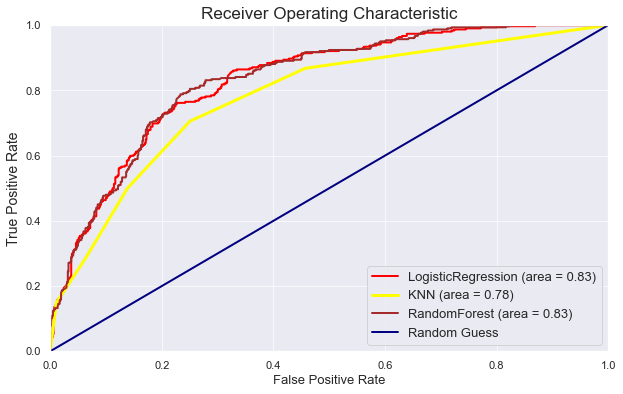

In [52]:
# plot the ROC curves
plt.figure(figsize=(10,6))

y_pred = logit.predict_proba(X_validate_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression (area = %0.2f)' % auc(fpr, tpr))
         
y_pred = knn.predict_proba(X_validate_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
plt.plot(fpr, tpr, color='yellow', lw=3, label='KNN (area = %0.2f)' % auc(fpr, tpr))


y_pred = clf.predict_proba(X_validate_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
plt.plot(fpr, tpr, color='brown', lw=2, label='RandomForest (area = %0.2f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

# The plot above shows that Area under Curve (AUC of Logistics Regression and Random Forest is higest 0.84.

# We finally chose to use Logistic Regression model since it is more robost (less variation) compared to Random Forest

### Finally we run our finalized model (logistic regression) on test dataset to confirm that the model is not overfitted

In [53]:
# Here we evaluate our finalized logistic regression model on test dataset
y_pred = logit.predict(X_test_scaled)
y_pred_proba = logit.predict_proba(X_test_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_test, yhat.churn))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1051
           1       0.50      0.79      0.61       356

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.81      0.75      0.76      1407



# The F1 value on test data is 0.61 compared to 0.63 on training and validate dataset. So we conclude that our model is not overfit and we can use for our predicting Churn.   Success!!

## Finally we generate a CSV file which predicts churn probability and churn prediction for whole dataset

In [124]:
y_df = df[['churn']]
X_df = df[['senior_citizen', 'tech_support', 'contract_type', 'internet_service_type','payment_type','tenure_years', 'total_charges']]

In [125]:
# Next we do onehot encoding for these variables
X_df = encode.encode(X_df,l)

In [126]:
# scale the whole dataset
X_df_scaled = encode.scale_minmax(X_df, column_list)

In [127]:
#Predict churn on df dataset using logit function
y_pred_proba = logit.predict_proba(X_df_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn_prob'], index = df.index)
t = 0.3
y_pred_proba['churn_prediction'] = (y_pred_proba.churn_prob > t).astype(int) 
y_pred_proba = y_pred_proba.drop(columns = ['no churn'])

In [128]:
# Generate final CSV file by merging customer_ids and probablity of customer churn
final_csv = df[['customer_id']]
final_csv = pd.merge(final_csv, y_pred_proba, left_index = True,right_index= True, how='left')
final_csv.to_csv('final_csv.csv')